# The Final Countdown

# ——————
# Regression
# ——————

## // Importing libraries //

In [190]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion # These ones are new!
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, Imputer

%matplotlib inline

sns.set_style('darkgrid')

## // Reading in the data //

In [191]:
train = pd.read_csv('train.csv')
train.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000


In [192]:
test = pd.read_csv('test.csv')
test.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New


### // Basic EDA //

In [193]:
# First I want the column names to be uniformly formatted just for consistency.

train.rename(columns= {col: col.lower().replace(' ','_') for col in train.columns}, inplace=True)
test.rename(columns= {col: col.lower().replace(' ','_') for col in test.columns}, inplace=True)

In [194]:
# For this run through, I want to keep it as basic and logical as possible.
# So I think I'm going to think about land (lot_area) + building_area (grlivarea + total_bsmt_sf + garage_area), location (neighborhood and zoning), and hyperized total quality.

In [195]:
# If that's not great, then I'll add in my idea for 'new house' and 'remodeled' features

### _Going after outliers right off the bat_

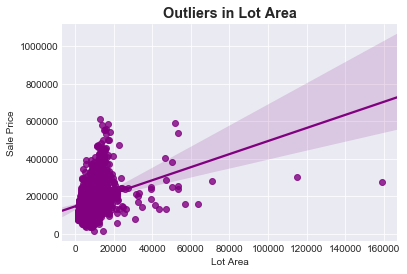

In [196]:
sns.regplot('lot_area', 'saleprice', train, color='purple')
plt.xlabel('Lot Area', fontsize = 'medium')
plt.ylabel('Sale Price', fontsize= 'medium', )
plt.title('Outliers in Lot Area', fontsize= 'x-large', fontweight='bold');

In [197]:
# Potential outliers above 100,000
# Let's chop them for now

In [198]:
train.loc[train.lot_area > 100000, :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
471,2116,906426060,50,RL,NaN,159000,Pave,NaN,IR2,Low,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
694,2072,905301050,20,RL,NaN,115149,Pave,NaN,IR2,Low,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000


In [199]:
train.drop([471, 694], inplace=True)

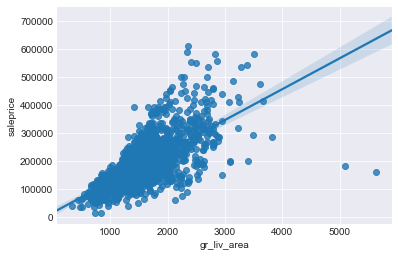

In [200]:
sns.regplot(train.gr_liv_area, train.saleprice, train);

In [201]:
train.loc[train.gr_liv_area > 5000, :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,...,0,NaN,NaN,Elev,17000,10,2007,New,Partial,183850


In [202]:
train.drop([960, 1885], inplace=True)

### _Let's go NaN hunting_:

In [203]:
train.isnull().sum().sort_values(ascending = False)

pool_qc            2039
misc_feature       1984
alley              1907
fence              1647
fireplace_qu       1000
lot_frontage        328
garage_cond         114
garage_finish       114
garage_yr_blt       114
garage_qual         114
garage_type         113
bsmt_exposure        58
bsmtfin_type_2       56
bsmt_cond            55
bsmt_qual            55
bsmtfin_type_1       55
mas_vnr_type         22
mas_vnr_area         22
bsmt_half_bath        2
bsmt_full_bath        2
garage_cars           1
garage_area           1
total_bsmt_sf         1
bsmt_unf_sf           1
bsmtfin_sf_2          1
bsmtfin_sf_1          1
exterior_2nd          0
exterior_1st          0
roof_matl             0
roof_style            0
                   ... 
heating               0
foundation            0
functional            0
sale_type             0
yr_sold               0
mo_sold               0
misc_val              0
pool_area             0
screen_porch          0
3ssn_porch            0
enclosed_porch  

In [204]:
# Need to impute garage_area and total_bsmt_sf for my building_sq_ft feature

In [205]:
train.garage_area.fillna(train.garage_area.median(), inplace=True)
train.total_bsmt_sf.fillna(train.total_bsmt_sf.median(), inplace=True)

In [206]:
# Next up is lot_frontage, let's take a look at other places in the similar neighborhood.

In [207]:
neigh_frontage_means = train.groupby('neighborhood')['lot_frontage'].mean().to_dict()

In [208]:
neigh_frontage_means['Blmngtn']

47.25

In [209]:
train['lot_frontage'].head(20);

In [210]:
# Imputing missing lot_frontage values with the average of one in the same neighborhood.

neigh_frontage_means = train.groupby('neighborhood')['lot_frontage'].mean().to_dict()

train['lot_frontage'] = train.apply(lambda x: neigh_frontage_means[x.neighborhood] if \
                                    np.isnan(x.lot_frontage) else x.lot_frontage, axis=1)

In [211]:
# Still have a couple NaN's, let's decide on what to do...
# Mean and median are very close so I'll do the mean.
train.lot_frontage.fillna(train.lot_frontage.mean(), inplace=True)

### _Let's make some nominal variables:_

In [212]:
# For zoning:

train['ms_zoning'] = train['ms_zoning'].astype('category')
train = pd.get_dummies(train, columns = ['ms_zoning'], drop_first = True)

# For neighborhood:

train['neighborhood'] = train['neighborhood'].astype('category')
train = pd.get_dummies(train, columns = ['neighborhood'], drop_first = True)

### _Let's make some ordinal variables:_

In [213]:
simple_qual_encoded = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1,
    'NA': 0,
    np.nan: 0
}

train['exter_qual'] = train['exter_qual'].map(simple_qual_encoded)
train['exter_cond'] = train['exter_cond'].map(simple_qual_encoded)
train['bsmt_qual'] = train['bsmt_qual'].map(simple_qual_encoded)
train['bsmt_cond'] = train['bsmt_cond'].map(simple_qual_encoded)
train['heating_qc'] = train['heating_qc'].map(simple_qual_encoded)
train['kitchen_qual'] = train['kitchen_qual'].map(simple_qual_encoded)
train['fireplace_qu'] = train['fireplace_qu'].map(simple_qual_encoded)
train['garage_qual'] = train['garage_qual'].map(simple_qual_encoded)
train['garage_cond'] = train['garage_cond'].map(simple_qual_encoded)
train['pool_qc'] = train['pool_qc'].map(simple_qual_encoded)

# Should write a function to "DRY" this up.

### _Let's manufacture some new features:_

In [214]:
# While it's still fresh:
train['overall_simple_qual'] = train.exter_qual + train.exter_cond + train.bsmt_qual + train.bsmt_cond +\
                                train.heating_qc + train.kitchen_qual + train.fireplace_qu + train.garage_qual +\
                                train.garage_cond + train.pool_qc

In [215]:
train['hyper_qual'] = train.overall_cond * train.overall_qual

train['building_area'] = train.gr_liv_area + train.total_bsmt_sf + train.garage_area

In [216]:
# We have our location dummies above

In [217]:
train.loc[train['year_built'] == train['yr_sold'], :];
# Want to be making a "New House" variable somehow...

train['new_house'] = (train['year_built'] == train['yr_sold']).as_matrix()

new_house_encoded = {
    False: 0,
    True: 1
}
train['new_house'] = train['new_house'].map(new_house_encoded)
train['new_house'].value_counts() # Yay!

0    1968
1      79
Name: new_house, dtype: int64

In [218]:
# Want to do the same thing but for a remodeled category:
train.loc[train['year_built'] != train['year_remod/add'], :];
train['remodeled'] = (train['year_built'] != train['year_remod/add']).as_matrix()
train['remodeled'] = train['remodeled'].map(new_house_encoded)

### _That should be plenty of features, hopefully not too many already..._

### _Let's clean the test data:_

In [219]:
test.garage_area.fillna(test.garage_area.median(), inplace=True)
test.total_bsmt_sf.fillna(test.total_bsmt_sf.median(), inplace=True)

In [220]:
test['lot_frontage'] = test.apply(lambda x: neigh_frontage_means[x.neighborhood] if np.isnan(x.lot_frontage) else x.lot_frontage, axis=1)

In [221]:
test['ms_zoning'] = test['ms_zoning'].astype('category')
test = pd.get_dummies(test, columns = ['ms_zoning'], drop_first = True)

test['neighborhood'] = test['neighborhood'].astype('category')
test = pd.get_dummies(test, columns = ['neighborhood'], drop_first = True)

In [222]:
test['exter_qual'] = test['exter_qual'].map(simple_qual_encoded)
test['exter_cond'] = test['exter_cond'].map(simple_qual_encoded)
test['bsmt_qual'] = test['bsmt_qual'].map(simple_qual_encoded)
test['bsmt_cond'] = test['bsmt_cond'].map(simple_qual_encoded)
test['heating_qc'] = test['heating_qc'].map(simple_qual_encoded)
test['kitchen_qual'] = test['kitchen_qual'].map(simple_qual_encoded)
test['fireplace_qu'] = test['fireplace_qu'].map(simple_qual_encoded)
test['garage_qual'] = test['garage_qual'].map(simple_qual_encoded)
test['garage_cond'] = test['garage_cond'].map(simple_qual_encoded)
test['pool_qc'] = test['pool_qc'].map(simple_qual_encoded)

In [223]:
test['overall_simple_qual'] = test.exter_qual + test.exter_cond + test.bsmt_qual + test.bsmt_cond +\
                                test.heating_qc + test.kitchen_qual + test.fireplace_qu + test.garage_qual +\
                                test.garage_cond + test.pool_qc

In [224]:
test['hyper_qual'] = test.overall_cond * test.overall_qual
test['building_area'] = test.gr_liv_area + test.total_bsmt_sf + test.garage_area

In [225]:
test['new_house'] = (test['year_built'] == test['yr_sold']).as_matrix()

new_house_encoded = {
    False: 0,
    True: 1
}
test['new_house'] = test['new_house'].map(new_house_encoded)

In [226]:
test.loc[test['year_built'] != test['year_remod/add'], :]

test['remodeled'] = (test['year_built'] != test['year_remod/add']).as_matrix()

test['remodeled'] = test['remodeled'].map(new_house_encoded)

### _Poking around our new features:_

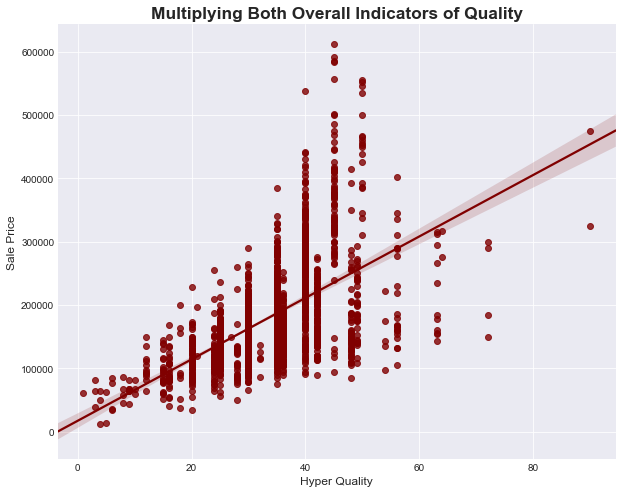

In [227]:
plt.figure(figsize=(10,8))
sns.regplot('hyper_qual', 'saleprice', train, color='maroon')
plt.xlabel('Hyper Quality', fontsize = 'large')
plt.ylabel('Sale Price', fontsize= 'large', )
plt.title('Multiplying Both Overall Indicators of Quality', fontsize= 'xx-large', fontweight='bold')
plt.savefig('hyper_quality.png');

In [228]:
# Hmm, seems like it is kind of correlated..?

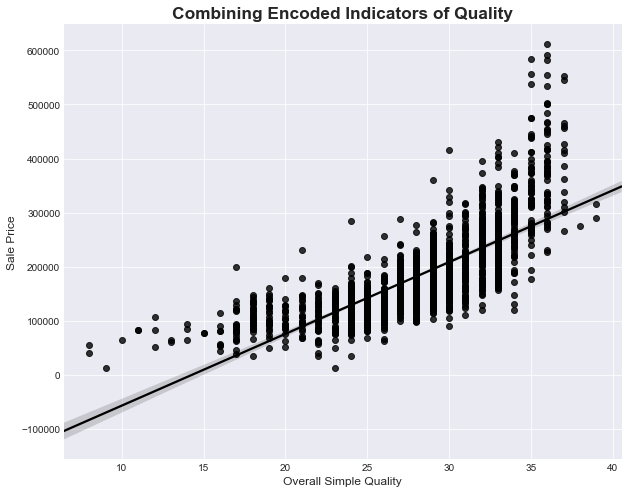

In [229]:
plt.figure(figsize=(10,8))
sns.regplot('overall_simple_qual', 'saleprice', train, color='black')
plt.xlabel('Overall Simple Quality', fontsize = 'large')
plt.ylabel('Sale Price', fontsize= 'large')
plt.title('Combining Encoded Indicators of Quality', fontsize= 'xx-large', fontweight='bold')
plt.savefig('overall_simple_quality.png');

In [230]:
# Seems like a very strong pattern that isn't meant for a straight linear regression...

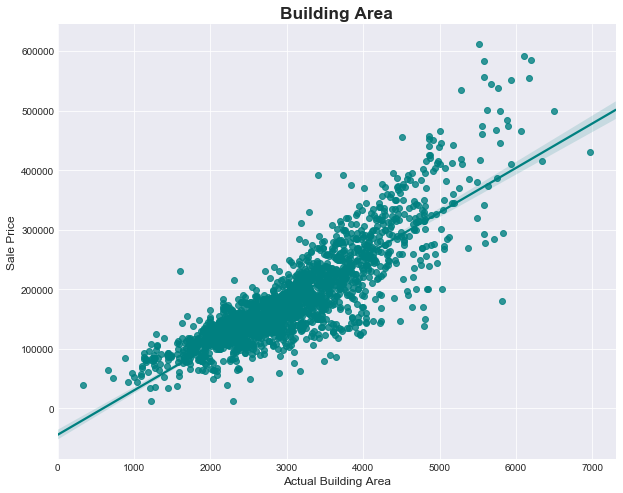

In [231]:
plt.figure(figsize=(10,8))
sns.regplot('building_area', 'saleprice', train, color='teal')
plt.xlabel('Actual Building Area', fontsize = 'large')
plt.ylabel('Sale Price', fontsize= 'large')
plt.title('Building Area', fontsize= 'xx-large', fontweight='bold')
plt.savefig('actual_building_area.png');

In [232]:
# Seems like a really good and simplified one.

### _Model time:_

In [233]:
features = ['lot_area', 'lot_frontage', 'building_area', 'hyper_qual', 'new_house', 'remodeled', 'overall_simple_qual']

neighborhood_features = [col for col in train.columns if 'neighborhood_' in col]

zoning_features = [col for col in train.columns if 'zoning_' in col]

all_features = features + neighborhood_features + zoning_features

In [234]:
y = train['saleprice']
X = train[all_features]

In [235]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 44)

In [236]:
imp = Imputer()
ss = StandardScaler()

lasso = Lasso(max_iter=2500)
ridge = Ridge(max_iter=2000)
enet = ElasticNet()

pipe = Pipeline([                               # Things need to be in order like a factory
#     ('features', features),
    ('imp', imp),
#     ('poly', poly),
    ('ss', ss),
    ('lasso', lasso),
#     ('ridge', ridge),
#     ('enet', enet),
])

In [237]:
params = {
    'imp__strategy': ['mean', 'median','most_frequent'],
    'lasso__alpha': np.arange(.001, .15, .0025),
#     'ridge__alpha': np.logspace(0, 5, 200),
#     'enet__alpha' : np.arange(.01, 1.0, .005),
#     'enet__l1_ratio': [.1, .5, .7,.9, .95, .99, 1]
}
rs = RandomizedSearchCV(pipe, param_distributions=params, n_iter=10)
rs.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2500,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'imp__strategy': ['mean', 'median', 'most_frequent'], 'lasso__alpha': array([ 0.001 ,  0.0035,  0.006 ,  0.0085,  0.011 ,  0.0135,  0.016 ,
        0.0185,  0.021 ,  0.0235,  0.026 ,  0.0285,  0.031 ,  0.0335,
        0.036 ,  0.0385,  0.041 ,  0.0435,  0.046 ,  0.0485,  0.051 ,...,  0.126 ,  0.1285,  0.131 ,  0.1335,  0.136 ,  0.1385,
        0.141 ,  0.1435,  0.146 ,  0.1485])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,


In [238]:
print (rs.best_score_)
print (rs.best_params_)

0.855576716247
{'lasso__alpha': 0.126, 'imp__strategy': 'most_frequent'}


In [239]:
rs.score(X_holdout, y_holdout)

0.84778911519487532

In [240]:
test['neighborhood_GrnHill'] = [0 for x in range(1, 880)]
test['neighborhood_Landmrk'] = [0 for x in range(1, 880)]
test['ms_zoning_C (all)'] = [0 for x in range(1, 880)]

In [241]:
X_test = test[all_features]

In [242]:
rs.best_estimator_

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
    verbose=0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.126, copy_X=True, fit_intercept=True, max_iter=2500,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [185]:
predictions = rs.best_estimator_.predict(X_test)

test['SalePrice'] = predictions

test = test.rename(columns={'id': 'Id'})
test.head(3)

,Id,pid,ms_subclass,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,...,neighborhood_Veenker,overall_simple_qual,hyper_qual,building_area,new_house,remodeled,neighborhood_GrnHill,neighborhood_Landmrk,ms_zoning_C (all),SalePrice
0,2658,902301120,190,69.000000,9142,Pave,Grvl,Reg,Lvl,AllPub,...,0,18,48,3388.0,0,1,0,0,0,164263.208546
1,2718,905108090,90,72.774648,9662,Pave,NaN,IR1,Lvl,AllPub,...,0,25,20,4514.0,0,0,0,0,0,200365.116958
2,2414,528218130,60,58.000000,17104,Pave,NaN,IR1,Lvl,AllPub,...,0,34,35,2576.0,1,0,0,0,0,215866.623614


In [186]:
test[['Id', 'SalePrice']].to_csv('p2_reg_29.csv', index=False)

# ——————
# Classification
# ——————

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [43]:
train = pd.read_csv('train.csv')
train.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000


In [44]:
test = pd.read_csv('test.csv')
test.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New


In [45]:
train.rename(columns= {col: col.lower().replace(' ','_') for col in train.columns}, inplace=True)
test.rename(columns= {col: col.lower().replace(' ','_') for col in test.columns}, inplace=True)

In [46]:
train['sale_condition'].value_counts(normalize=True)

Normal     0.826914
Partial    0.079961
Abnorml    0.064359
Family     0.014139
Alloca     0.009264
AdjLand    0.005363
Name: sale_condition, dtype: float64

In [47]:
# Abnormal is JUST 'Abnorml', everything else is Normal
# But I'm going to throw a little wrench in, just to try and not predict ALL 0's and to separate myself from the
# rest of the submissions.

encoded_conditon = {
    'Abnorml': 1,
    'Partial': 1,
    'AdjLand': 0,
    'Family': 0,
    'Normal': 0,
    'Alloca': 0
}
train['sale_condition'] = train['sale_condition'].map(encoded_conditon)
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,0,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,0,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,1,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,0,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,0,138500


In [49]:
train.sale_condition.value_counts(normalize=True)

# Our baseline is about 85.5%

0    0.85568
1    0.14432
Name: sale_condition, dtype: float64

In [50]:
nonnull_numeric_shared = (train._get_numeric_data().isnull().sum() == 0) & (test._get_numeric_data().isnull().sum() == 0)
nonnull_numeric_shared

1st_flr_sf          True
2nd_flr_sf          True
3ssn_porch          True
bedroom_abvgr       True
bsmt_full_bath     False
bsmt_half_bath     False
bsmt_unf_sf        False
bsmtfin_sf_1       False
bsmtfin_sf_2       False
enclosed_porch      True
fireplaces          True
full_bath           True
garage_area        False
garage_cars        False
garage_yr_blt      False
gr_liv_area         True
half_bath           True
id                  True
kitchen_abvgr       True
lot_area            True
lot_frontage       False
low_qual_fin_sf     True
mas_vnr_area       False
misc_val            True
mo_sold             True
ms_subclass         True
open_porch_sf       True
overall_cond        True
overall_qual        True
pid                 True
pool_area           True
sale_condition     False
saleprice          False
screen_porch        True
total_bsmt_sf      False
totrms_abvgrd       True
wood_deck_sf        True
year_built          True
year_remod/add      True
yr_sold             True


In [51]:
features = ['1st_flr_sf', '2nd_flr_sf', '3ssn_porch', 'bedroom_abvgr', 'enclosed_porch', 'fireplaces', 'full_bath', 'gr_liv_area', 'half_bath', 'id', 'kitchen_abvgr', 'lot_area', 'low_qual_fin_sf', 'misc_val', 'mo_sold', 'ms_subclass', 'open_porch_sf', 'overall_cond', 'overall_qual', 'pid', 'pool_area', 'screen_porch', 'totrms_abvgrd', 'wood_deck_sf', 'year_built', 'year_remod/add', 'yr_sold']

In [52]:
train.corr()['sale_condition'].abs().sort_values(ascending=False)[0:7]

sale_condition    1.000000
garage_yr_blt     0.196279
bsmt_unf_sf       0.176859
saleprice         0.172761
year_built        0.165330
overall_cond      0.160077
total_bsmt_sf     0.157732
Name: sale_condition, dtype: float64

In [53]:
train.loc[train['bsmt_unf_sf'].isnull(), :]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,saleprice
1327,1342,903230120,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,4,2008,ConLD,1,79000


In [54]:
# Let's just drop it! YOLO!

train.dropna(subset = ['bsmt_unf_sf'], how = 'any', inplace=True)

train.shape

(2050, 82)

In [55]:
train.garage_yr_blt.isnull().sum()

114

In [56]:
# Let's get really drop happy

train.dropna(subset = ['garage_yr_blt'], how = 'any', inplace=True)

train.shape

(1936, 82)

In [57]:
corr_features = ['bsmt_unf_sf', 'overall_cond', 'garage_yr_blt', 'total_bsmt_sf', 'yr_sold']

### _Model time!_

In [ ]:
# Alternate reality aka v2

# X = train[corr_features]
# y = train['sale_condition']

In [58]:
# First reality aka v1

X = train[features]
y = train['sale_condition']

In [59]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 69, stratify=y)

ss = StandardScaler()
X_ts = ss.fit_transform(X_train) #ONLY FIT TO TRAINING DATA
X_hs = ss.transform(X_holdout) #TRANSFORM BOTH

knn = KNeighborsClassifier()

cross_val_score(knn, X_ts, y_train).mean()

0.85606060606060608

In [60]:
# So like about the same as the baseline...

params = {
    'n_neighbors': range(2,30),
    'p': [1,2],
    'weights': ['uniform', 'distance']
}
gs = GridSearchCV(knn, params)
gs.fit(X_ts, y_train)

print (gs.best_params_)
print (gs.best_score_)

{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
0.871212121212


In [61]:
# Still like the same as baseline...

# Scoring it on the holdout set to make sure we're not overfitting
# Compare to the cross_val_score

gs.score(X_hs, y_holdout)

0.86776859504132231

In [ ]:
# Slightly better?

In [62]:
# corr_features

# test.shape

# test.garage_yr_blt.isnull().sum()

# median_garage_yr_blt = train['garage_yr_blt'].median()

# test['garage_yr_blt'] = test['garage_yr_blt'].fillna(median_garage_yr_blt)

X_test = test[features]
X_test_scaled = ss.transform(X_test)
X_test_scaled

test['sale_condition'] = gs.predict(X_test_scaled)

In [63]:
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2006,New,0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,WD,0
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,185,0,NaN,NaN,NaN,0,7,2009,WD,0


In [65]:
test.sale_condition.value_counts()
# I can live with those numbers

0    865
1     14
Name: sale_condition, dtype: int64

In [66]:
test = test.rename(columns={'id': 'Id', 'sale_condition': 'Sale Condition'})
test.head()

,Id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,Sale Condition
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,0
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,0
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2006,New,0
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,WD,0
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,185,0,NaN,NaN,NaN,0,7,2009,WD,0


In [67]:
# test[['Id', 'Sale Condition']].to_csv('p2_class_1.csv', index=False)

# test[['Id', 'Sale Condition']].to_csv('p2_class_2.csv', index=False)

test[['Id', 'Sale Condition']].to_csv('p2_class_5.csv', index=False)

In [55]:
# I wanted to do the classification as an indpendent one of the regression.
# Given another couple cracks at it, I would probably try it using the same features I had manufactured for
# that one.